In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Gathering Data

In [2]:
image_dir = 'C:/Users/kokum/Downloads/Data set/May12_2030(Both)/IMG'
driving_log_path = 'C:/Users/kokum/Downloads/Data set/May12_2030(Both)/driving_log.csv'

df = pd.read_csv(driving_log_path, header=None)
df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

df = shuffle(df)

## Data Preprocessing 

### Image Loading
- removing whitespaces in the image path
- Converting to RGB

In [3]:
def load_image(image_path):
    image = cv2.imread(image_path.strip())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Cropping
cropping off unneccary parts of the image
- 60 pixels from top to remove the sky
- 25 pixels from bottom to remove the hood 

In [4]:
def crop(image):
    return image[60:-25, :, :]

### Resizing
Resizing image to 244*244 through interpolation

In [5]:
def resize(image):
    return cv2.resize(image, (224, 224))

### Normalizing
Convert pixel values from 0-255 to (-1)-1

In [6]:
def normalize(image):
    return image / 127.5 - 1.0

### Random Flipping
randomly mirroring images wih the streeing angle to increase the symmetric behaviour of the data

In [7]:
def random_flip(image, steering):
    if np.random.rand() < 0.5:
        return cv2.flip(image, 1), -steering
    return image, steering

### Running the Data Augmentation

In [8]:
def preprocess_and_augment(image_path, steering_angle):
    image = load_image(os.path.join(image_dir, os.path.basename(image_path)))
    image = crop(image)
    image = resize(image)
    image, steering_angle = random_flip(image, steering_angle)
    image = normalize(image)
    return image, steering_angle

### Viewing Augmented Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901960784313725..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9921568627450981..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.984

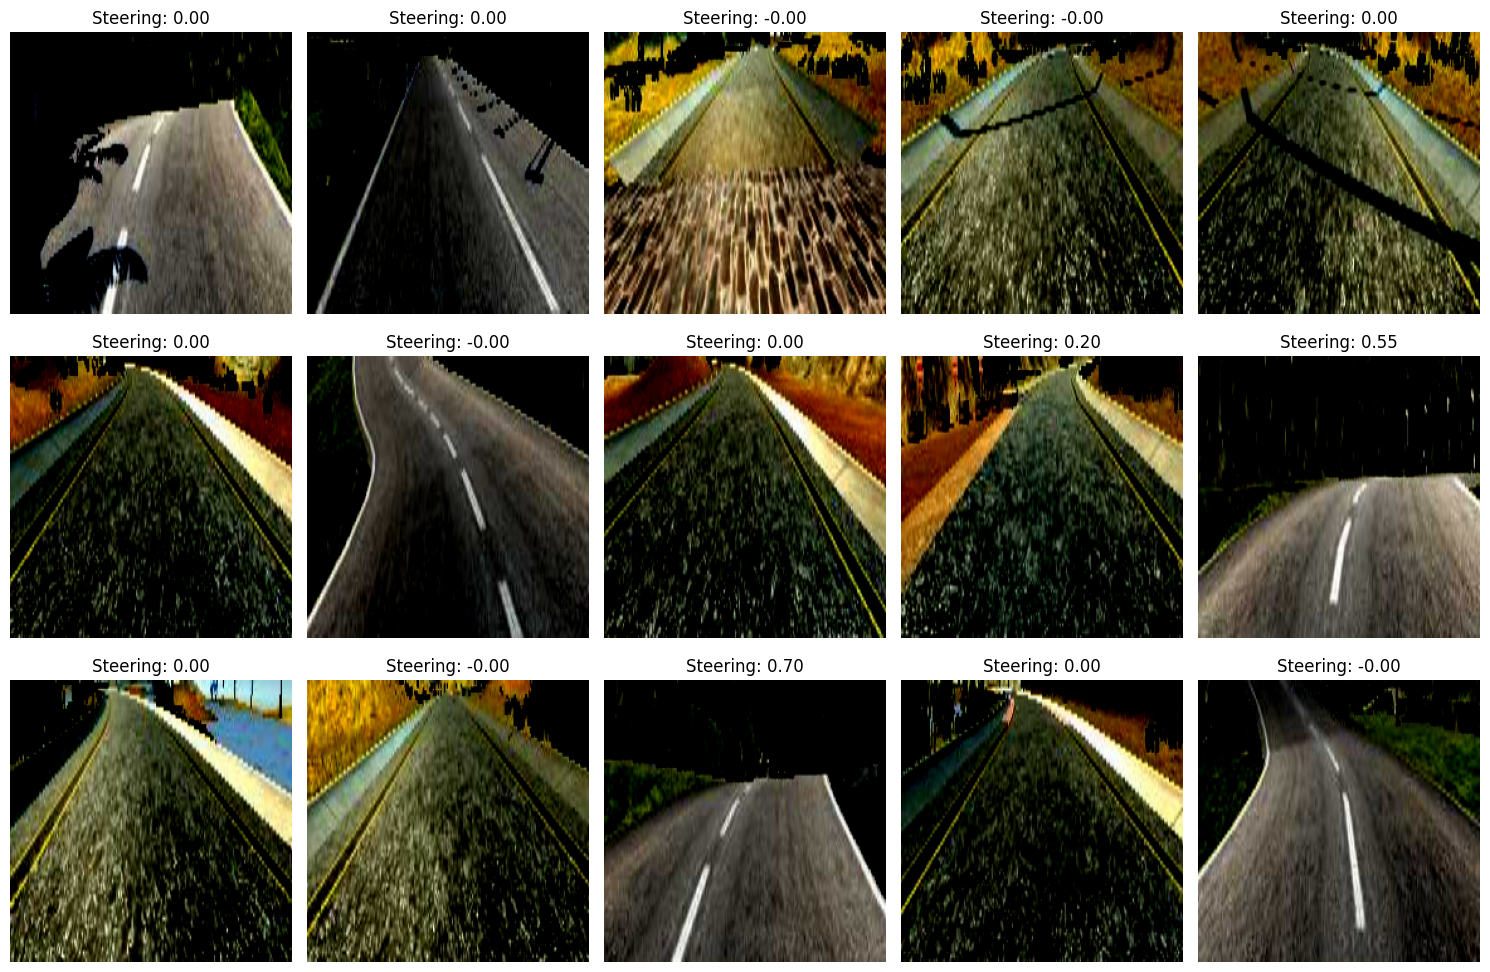

In [9]:
import matplotlib.pyplot as plt

num_samples = 15

plt.figure(figsize=(15, 10))

for i in range(num_samples):
    # Get file path and steering angle from CSV
    image_path = df.iloc[i]['center']
    angle = df.iloc[i]['steering']
    
    # Apply full preprocessing + augmentation pipeline
    image, adjusted_angle = preprocess_and_augment(image_path, angle)

    # Plot it
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.title(f"Steering: {adjusted_angle:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
def data_generator(dataframe, batch_size=32):

    num_samples = len(dataframe)

    while True:  # Loop forever (required for Keras .fit)
        dataframe = shuffle(dataframe)

        for offset in range(0, num_samples, batch_size):
            batch_df = dataframe.iloc[offset:offset + batch_size]

            images = []
            angles = []

            for _, row in batch_df.iterrows():
                img_path = row['center']  # <-- This must match the column name in your CSV
                angle = row['steering']   # <-- Same here
                image, angle = preprocess_and_augment(img_path, angle)
                images.append(image)
                angles.append(angle)

            yield np.array(images), np.array(angles)




In [11]:
df = shuffle(df)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


Model

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet50Model(nn.Module):
    def __init__(self, output_dim=1, pretrained=True, freeze_backbone=True):
        super(ResNet50Model, self).__init__()
        self.base_model = models.resnet50(pretrained=pretrained)

        # Optionally freeze the backbone
        if freeze_backbone:
            for param in self.base_model.parameters():
                param.requires_grad = False

        # Replace final FC layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, output_dim)  # Output: Steering angle (or [angle, throttle] if output_dim=2)
        )

    def forward(self, x):
        return self.base_model(x)

# Usage Example
if __name__ == "__main__":
    model = ResNet50Model(output_dim=1)
    dummy_input = torch.randn(1, 3, 224, 224)  # Example input size
    output = model(dummy_input)
    print("Output shape:", output.shape)


c:\Users\kokum\anaconda3\envs\CNNCar\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kokum\anaconda3\envs\CNNCar\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([1, 1])


Code to save model after each epoch

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import pandas as pd
from resnet50_model import ResNet50Model

# --- Custom Dataset ---
class DrivingDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.basename(self.data.iloc[idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        angle = torch.tensor([float(self.data.iloc[idx, 3])], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, angle

# --- Hyperparameters ---
EPOCHS = 20
BATCH_SIZE = 32
LR = 0.0005
VAL_SPLIT = 0.2
IMG_DIR = 'C:/Users/kokum/Downloads/Data set/May12_2030(Both)/IMG'
CSV_FILE = 'C:/Users/kokum/Downloads/Data set/May12_2030(Both)/driving_log.csv'

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# --- Dataset and Split ---
full_dataset = DrivingDataset(CSV_FILE, IMG_DIR, transform=transform)
val_size = int(VAL_SPLIT * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Model, Loss, Optimizer ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50Model(output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- Training Loop ---
print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for images, angles in train_loader:
        images, angles = images.to(device), angles.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, angles)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, angles in val_loader:
            images, angles = images.to(device), angles.to(device)
            outputs = model(images)
            loss = criterion(outputs, angles)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"resnet50_epoch{epoch+1}.pth")
    print(f"Saved model to resnet50_epoch{epoch+1}.pth")

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = ResNet50Model()  # Replace with your actual model class
print(f"Total Trainable Parameters: {count_parameters(model):,}")

c:\Users\kokum\anaconda3\envs\CNNCar\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kokum\anaconda3\envs\CNNCar\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Trainable Parameters: 524,801
